In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2
from scipy import sparse
from sklearn.decomposition import PCA

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

### Đọc dữ liệu

In [3]:
# đọc tên các lớp :  có 9 loại
# DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [4]:
data = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

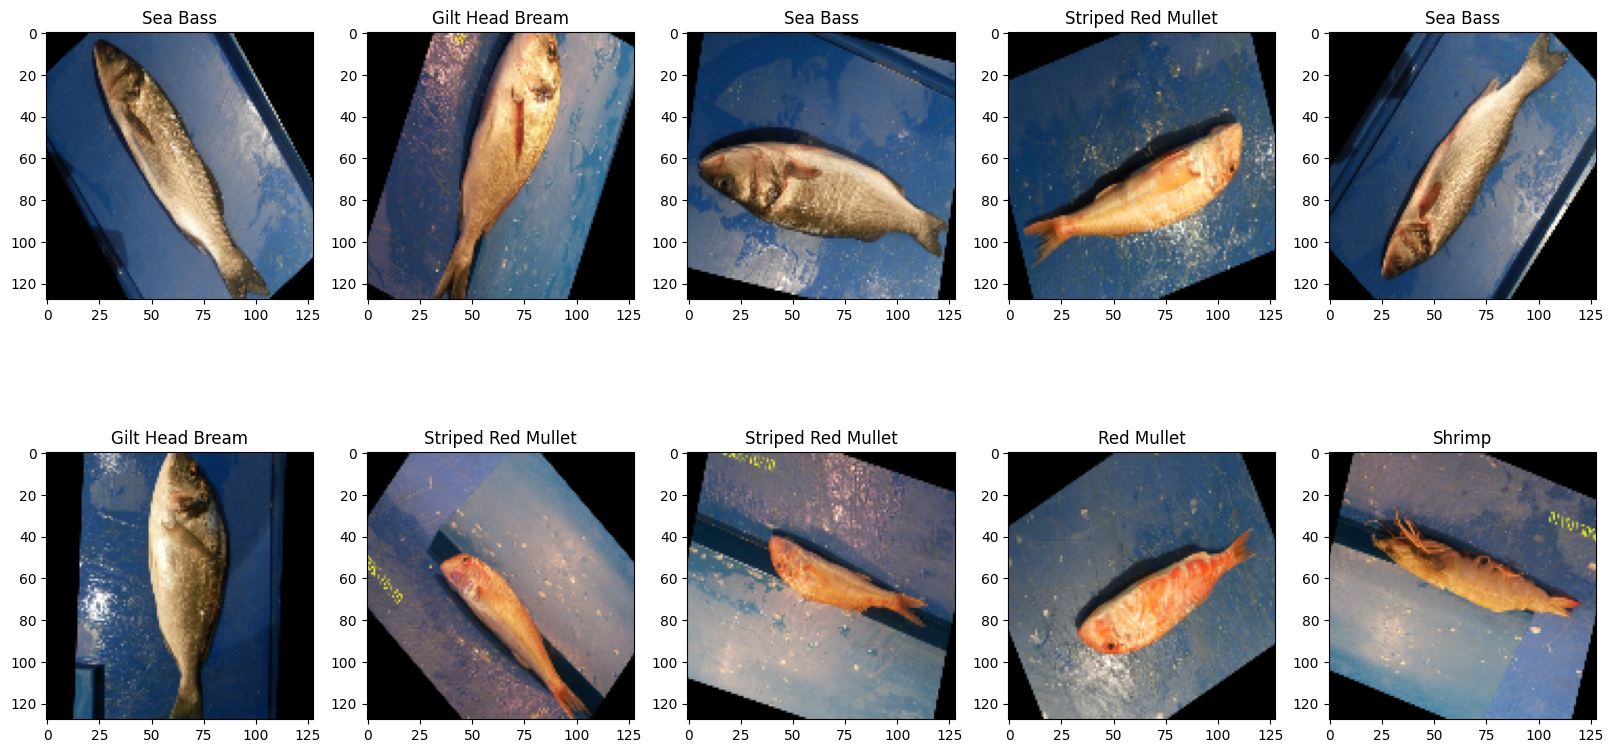

In [5]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [6]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [7]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [8]:
# giảm chiều dữ liệu image
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [9]:
# duỗi ảnh thành vector
images = images.reshape(images.shape[0], -1) # 9000 ảnh, mỗi ảnh có 224x224x3 = 150528 pixel

In [10]:
# giảm chiều dữ liệu
pca = PCA(0.95)
images = pca.fit_transform(images)

In [11]:
images.shape

(9000, 1087)

In [12]:
labels.shape

(9000,)

### Chia dữ liệu Train và Validation

In [13]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 1087), (1800, 1087), (7200,), (1800,))

In [14]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

### Xây dựng model

In [15]:
def convert_labels(y, C): # C là số lượng nhãn, hàm này chuyển vector nhãn y sang dạng ma trận one-hot-coding
    Y = sparse.coo_matrix((np.ones_like(y),
                           (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

In [16]:
def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    return A

In [17]:
def softmax_regression(X, y, W_init, eta, tol = 1e-6, max_count = 100000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C) # Y là ma trận one-hot coding của y
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 10000
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)

            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1

            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

In [18]:
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def predict(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [19]:
X_train = train_images.T
X_val = val_images.T

In [20]:
X_train.shape

(1087, 7200)

In [21]:
eta = 0.05
d = X_train.shape[0] # số chiều của dữ liệu
W_init = np.random.randn(X_train.shape[0], 9) # khởi tạo W có kích thước là (d, C) d là số chiều của dữ liệu, C là số lượng nhãn
print(W_init.shape)
W = softmax_regression(X_train, train_labels, W_init, eta)
# print(W[-1])

(1087, 9)


In [22]:
# ỉn ra giá trị dự đoán và giá trị thực tế
y_pred = predict(W[-1], X_val)

In [23]:
# in ma trận confusion
cm = confusion_matrix(val_labels, y_pred)

Text(0.5, 23.52222222222222, 'Predicted label')

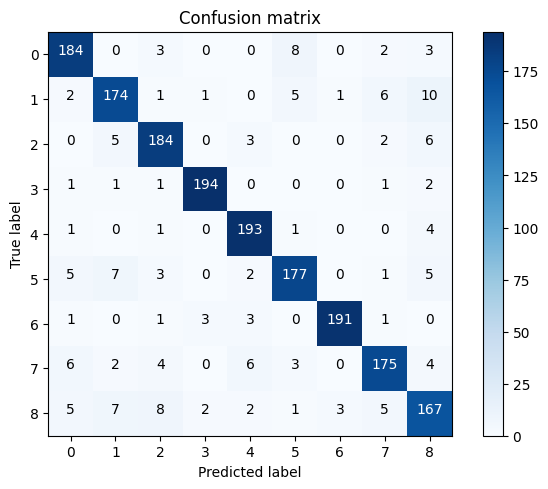

In [24]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [25]:
# tính độ chính xác
print('Accuracy %s' % accuracy_score(val_labels, y_pred))
# in recall
print('Recall: %s' % recall_score(val_labels, y_pred, average=None))
# in precision
print('Precision: %s' % precision_score(val_labels, y_pred, average=None))

Accuracy 0.9105555555555556
Recall: [0.92  0.87  0.92  0.97  0.965 0.885 0.955 0.875 0.835]
Precision: [0.89756098 0.8877551  0.89320388 0.97       0.92344498 0.90769231
 0.97948718 0.90673575 0.83084577]


#### Test Model

In [26]:
data_test = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [27]:
# shuffle data_test
import random
random.shuffle(data_test)

In [28]:
# tạo image và label từ data
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [29]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [30]:
# giảm chiều dữ liệu image
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 128, 128, 3)

In [31]:
# duỗi ảnh thành vector
test_images = test_images.reshape(430, -1) # 430 ảnh, mỗi ảnh có 224x224x3 = 150528 pixel

In [32]:
test_images = pca.transform(test_images)

In [33]:
# dự đoán kết quả
y_pred = predict(W[-1], test_images.T)

Text(0.5, 23.52222222222222, 'Predicted label')

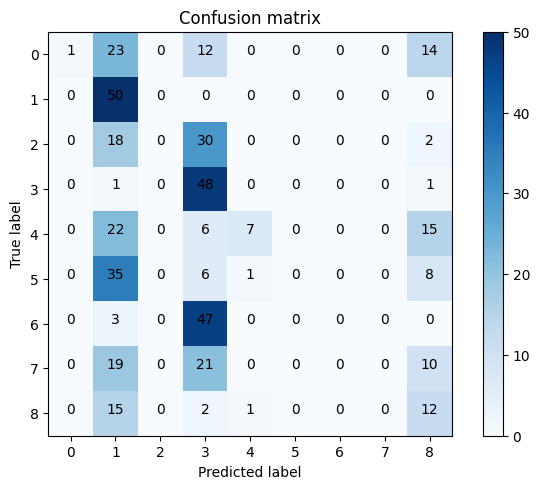

In [34]:
cm = confusion_matrix(test_labels, y_pred)

classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [35]:
# tính độ chính xác
print('Accuracy %s' % accuracy_score(test_labels, y_pred))
# in recall
print('Recall: %s' % recall_score(test_labels, y_pred, average=None))
# in precision
print('Precision: %s' % precision_score(test_labels, y_pred, average=None))

Accuracy 0.2744186046511628
Recall: [0.02 1.   0.   0.96 0.14 0.   0.   0.   0.4 ]
Precision: [1.         0.2688172  0.         0.27906977 0.77777778 0.
 0.         0.         0.19354839]


c:\Users\vannt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
